# 1 - Import requirements

In [1]:
# !pip install pytorch-optimizer

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
# from pytorch_optimizer import SAM

from tqdm import tqdm

# 2 - Prepare data

In [3]:
label_mapping = {
    'BUY': 0,
    'SELL': 1,
    'HOLD': 2
}

def map_label(x):
    return label_mapping[x] if x in label_mapping else x

In [4]:
def load_shape(shape_path):
    with open(shape_path, 'r') as f:
        shape = f.readlines()
        n_samples = int(shape[0])
        seq_len = int(shape[1])
        n_features = int(shape[2])
    return n_samples, seq_len, n_features

class TradingDataset(Dataset):
    def __init__(self, save_path, n_samples, sequence_length, n_features):
        self.save_path = save_path
        self.n_samples = n_samples
        self.sequences = np.memmap(f'{save_path}/sequences.dat', dtype=np.float32, mode='r', 
                                 shape=(n_samples, sequence_length, n_features))
        self.labels = np.memmap(f'{save_path}/labels.dat', dtype=np.int64, mode='r', 
                              shape=(n_samples,))
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        seq = self.sequences[idx].copy()  # Tạo bản sao writable
        lbl = self.labels[idx].copy()
        return torch.from_numpy(seq).float(), torch.from_numpy(np.array([lbl])).long()[0]

def prepare_transformer_input(train_shape_path, val_shape_path, test_shape_path, data_path, batch_size=32):    
    n_train_samples, sequence_length, n_features = load_shape(train_shape_path)
    n_val_samples, _, _ = load_shape(val_shape_path)
    n_test_samples, _, _ = load_shape(test_shape_path)
    
    train_path = f'{data_path}/train'
    val_path = f'{data_path}/val'
    test_path = f'{data_path}/test'
    
    # Tạo datasets
    train_dataset = TradingDataset(train_path, n_train_samples, sequence_length, n_features)
    val_dataset = TradingDataset(val_path, n_val_samples, sequence_length, n_features)
    test_dataset = TradingDataset(test_path, n_test_samples, sequence_length, n_features)
    
    # Tạo dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [5]:
train_shape_path = '/kaggle/input/classification/train/shape.txt'
val_shape_path = '/kaggle/input/classification/val/shape.txt'
test_shape_path = '/kaggle/input/classification/test/shape.txt'


train_loader, val_loader, test_loader = prepare_transformer_input(
    train_shape_path, val_shape_path, test_shape_path,
    data_path='/kaggle/input/classification',
    batch_size=32
)

In [6]:
# Kiểm tra
sample_batch = next(iter(train_loader))
print("Batch input shape:", sample_batch[0].shape)
print("Batch labels shape:", sample_batch[1].shape)
print("\nExample input shape for Transformer:", sample_batch[0][0].shape)
print(sample_batch[0][0])
print("Number of batches:", len(train_loader))

Batch input shape: torch.Size([32, 128, 37])
Batch labels shape: torch.Size([32])

Example input shape for Transformer: torch.Size([128, 37])
tensor([[-0.6103, -0.0958, -0.5541,  ..., -0.6439,  0.8317,  0.8950],
        [-0.5905, -0.1923, -1.0262,  ..., -0.6439,  0.8317,  0.8950],
        [-0.4117, -0.3853, -1.2135,  ..., -0.6439,  0.8317,  0.8950],
        ...,
        [-0.6302, -0.2406, -1.5179,  ..., -1.1719,  0.8317,  0.8950],
        [-0.6103,  0.2660,  1.5382,  ..., -1.1719,  0.8317,  0.8950],
        [-0.2131, -0.4335, -0.9377,  ..., -1.1719,  0.8317,  0.8950]])
Number of batches: 3283


# 3 - Build model

In [7]:
class HybridTradingModel(nn.Module):
    def __init__(self, num_features, num_classes=3, d_model=128, nhead=8, dim_feedforward=512, num_layers=3):
        super().__init__()
        
        # 1. CNN Branch (cho feature extraction)
        self.cnn = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # 2. Transformer Branch
        self.transformer_proj = nn.Linear(num_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 3. Fusion & Classification
        self.fusion = nn.Linear(128 + d_model, 256)  # CNN output + Transformer output
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x shape: [batch, seq_len, num_features]
        
        # CNN Path (requires [batch, channels, seq_len])
        cnn_features = self.cnn(x.permute(0, 2, 1))  # [batch, 128, seq_len//2]
        cnn_features = cnn_features.mean(dim=-1)      # Global Avg Pooling [batch, 128]
        
        # Transformer Path
        transformer_features = self.transformer_proj(x)  # [batch, seq_len, d_model]
        transformer_features = self.transformer(transformer_features)  # [batch, seq_len, d_model]
        transformer_features = transformer_features.mean(dim=1)  # Pooling [batch, d_model]
        
        # Fusion
        combined = torch.cat([cnn_features, transformer_features], dim=-1)
        return self.classifier(self.fusion(combined))

N_FEATURES = 37
model = HybridTradingModel(num_features=N_FEATURES, num_classes=3, d_model=512, nhead=8, dim_feedforward=2048, num_layers=6)

In [9]:
from torchinfo import summary
print(summary(model, (32, 128, 37)))

Layer (type:depth-idx)                        Output Shape              Param #
HybridTradingModel                            [32, 3]                   --
├─Sequential: 1-1                             [32, 128, 64]             --
│    └─Conv1d: 2-1                            [32, 64, 128]             7,168
│    └─ReLU: 2-2                              [32, 64, 128]             --
│    └─MaxPool1d: 2-3                         [32, 64, 64]              --
│    └─Conv1d: 2-4                            [32, 128, 64]             24,704
│    └─ReLU: 2-5                              [32, 128, 64]             --
├─Linear: 1-2                                 [32, 128, 512]            19,456
├─TransformerEncoder: 1-3                     [32, 128, 512]            --
│    └─ModuleList: 2-6                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [32, 128, 512]            3,152,384
│    │    └─TransformerEncoderLayer: 3-2      [32, 128, 512]            3,152

In [10]:
# model(sample_batch[0]).shape, sample_batch[1].shape

# 4 - Train and Evaluate model

In [11]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        """
        patience: Số epoch chờ mà không cải thiện trước khi dừng
        min_delta: Độ cải thiện tối thiểu để coi là tốt hơn
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            
def eval_model(model, val_loader, criterion, device):
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, unit='batch', desc='\tEvaluating: '):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, -1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def train_model(model, train_loader, criterion, optimizer, device, scheduler=None):
    model.to(device)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for images, labels in tqdm(train_loader, unit='batch', desc=f'\tTraining: '):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, -1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    if scheduler is not None:
        scheduler.step()
    
    return epoch_loss, epoch_acc

In [14]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_train_samples, _, _ = load_shape('/kaggle/input/classification/train/shape.txt')
train_labels = np.memmap(f'/kaggle/input/classification/train/labels.dat', dtype=np.int64, mode='r', 
                              shape=(n_train_samples,))
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(DEVICE))

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
NUM_EPOCHS = 20
PATIENCE = 3
MIN_DELTA = 0.0005
torch.cuda.empty_cache()

model = nn.DataParallel(model)
    
train_losses = []
train_accs = []
val_losses = []
val_accs = []

early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)

for epoch in range(NUM_EPOCHS):
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}]')
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = eval_model(model, val_loader, criterion, DEVICE)
    
    print(f'\tTrain Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    print(f'\tVal Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Kiểm tra Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break
    print('===================================================')

Epoch [1/20]


	Evaluating: 100%|██████████| 1097/1097 [00:42<00:00, 26.10batch/s]


	Train Loss: 1.0610, Train Accuracy: 46.52%
	Val Loss: 1.0720, Val Accuracy: 45.76%
Epoch [2/20]


	Evaluating: 100%|██████████| 1097/1097 [00:38<00:00, 28.73batch/s]


	Train Loss: 1.0523, Train Accuracy: 49.41%
	Val Loss: 1.0681, Val Accuracy: 45.89%
Epoch [3/20]


	Evaluating: 100%|██████████| 1097/1097 [00:37<00:00, 29.02batch/s]


	Train Loss: 1.0508, Train Accuracy: 49.49%
	Val Loss: 1.0644, Val Accuracy: 45.26%
Epoch [4/20]


	Evaluating: 100%|██████████| 1097/1097 [00:37<00:00, 29.16batch/s]


	Train Loss: 1.0483, Train Accuracy: 49.38%
	Val Loss: 1.0656, Val Accuracy: 43.81%
EarlyStopping counter: 1/3
Epoch [5/20]


	Evaluating: 100%|██████████| 1097/1097 [00:37<00:00, 29.25batch/s]


	Train Loss: 1.0486, Train Accuracy: 49.64%
	Val Loss: 1.0639, Val Accuracy: 43.78%
Epoch [6/20]


	Evaluating: 100%|██████████| 1097/1097 [00:37<00:00, 29.29batch/s]


	Train Loss: 1.0473, Train Accuracy: 49.35%
	Val Loss: 1.0627, Val Accuracy: 41.70%
Epoch [7/20]


	Evaluating: 100%|██████████| 1097/1097 [00:37<00:00, 29.02batch/s]


	Train Loss: 1.0469, Train Accuracy: 49.58%
	Val Loss: 1.0620, Val Accuracy: 42.69%
Epoch [8/20]


	Evaluating: 100%|██████████| 1097/1097 [00:37<00:00, 29.16batch/s]


	Train Loss: 1.0462, Train Accuracy: 49.45%
	Val Loss: 1.0620, Val Accuracy: 42.49%
EarlyStopping counter: 1/3
Epoch [9/20]


	Evaluating: 100%|██████████| 1097/1097 [00:37<00:00, 29.32batch/s]


	Train Loss: 1.0454, Train Accuracy: 49.01%
	Val Loss: 1.0610, Val Accuracy: 42.70%
Epoch [10/20]


	Evaluating: 100%|██████████| 1097/1097 [00:37<00:00, 29.29batch/s]


	Train Loss: 1.0447, Train Accuracy: 49.25%
	Val Loss: 1.0596, Val Accuracy: 43.87%
Epoch [11/20]


	Evaluating: 100%|██████████| 1097/1097 [00:37<00:00, 29.12batch/s]


	Train Loss: 1.0439, Train Accuracy: 49.03%
	Val Loss: 1.0603, Val Accuracy: 43.40%
EarlyStopping counter: 1/3
Epoch [12/20]


	Evaluating: 100%|██████████| 1097/1097 [00:37<00:00, 29.09batch/s]


	Train Loss: 1.0428, Train Accuracy: 49.16%
	Val Loss: 1.0607, Val Accuracy: 42.25%
EarlyStopping counter: 2/3
Epoch [13/20]


	Evaluating: 100%|██████████| 1097/1097 [00:37<00:00, 29.09batch/s]

	Train Loss: 1.0417, Train Accuracy: 48.72%
	Val Loss: 1.0598, Val Accuracy: 42.65%
EarlyStopping counter: 3/3
Early stopping triggered!


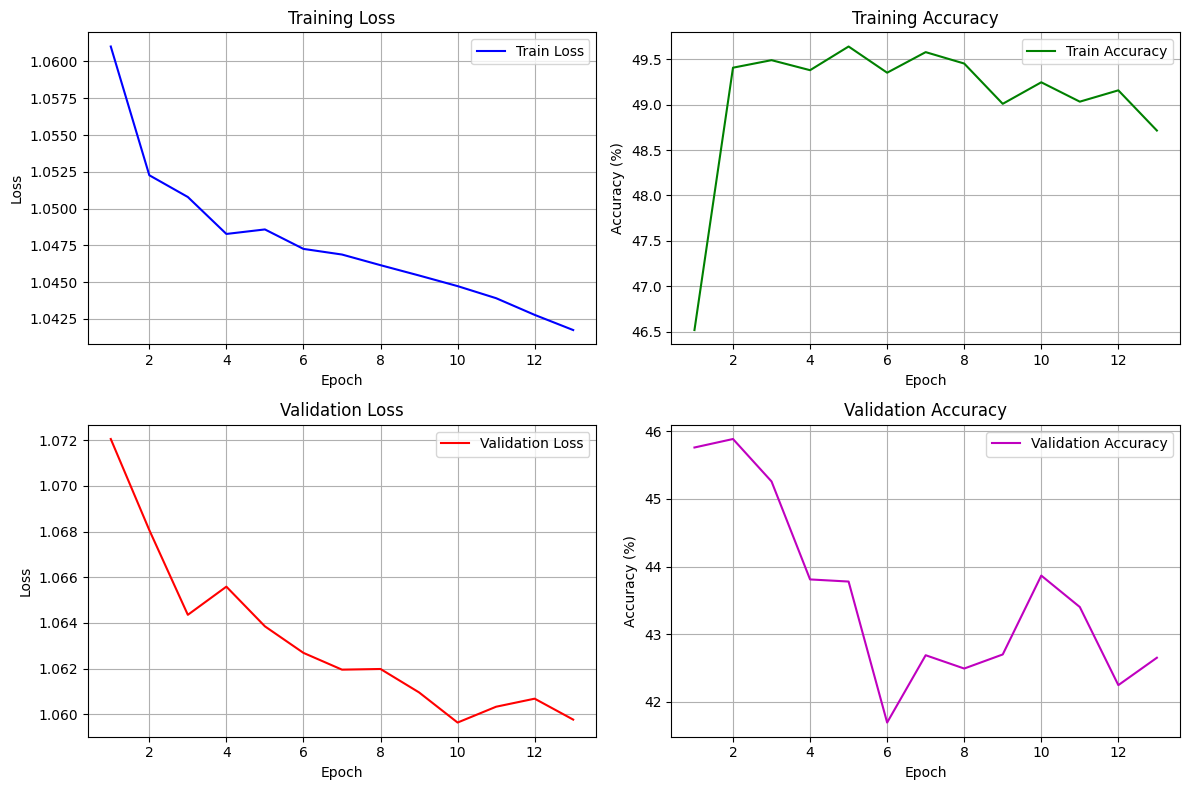

In [16]:
import matplotlib.pyplot as plt
def plot_training_results(train_losses, train_accs, val_losses, val_accs):
    """
    Vẽ biểu đồ kết quả huấn luyện: loss và accuracy cho train và validation.
    
    Parameters:
    - train_losses: List các giá trị loss của train qua các epoch
    - train_accs: List các giá trị accuracy của train qua các epoch
    - val_losses: List các giá trị loss của validation qua các epoch
    - val_accs: List các giá trị accuracy của validation qua các epoch
    """
    epochs = range(1, len(train_losses) + 1)
    
    # Tạo figure với 2x2 subplot
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Train Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Train Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accs, 'g-', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Validation Loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Subplot 4: Validation Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, val_accs, 'm-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Điều chỉnh layout và hiển thị
    plt.tight_layout()
    plt.show()

plot_training_results(train_losses, train_accs, val_losses, val_accs)

In [17]:
torch.save(model.state_dict(), 'model.pth')

In [18]:
def test_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)  # [B, seq_len, n_features]
            batch_y = batch_y.to(device)

            outputs = model(batch_x)  # Expecting [B, num_classes]
            preds = torch.argmax(outputs, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    target_names = ['BUY', 'SELL', 'HOLD']
    cm = confusion_matrix(all_labels, all_preds)
    print('Confusion matrix:')
    print(pd.DataFrame(cm, columns=target_names, index=target_names))
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=4, zero_division=0))

In [19]:
test_model(model, train_loader, DEVICE)

Confusion matrix:
        BUY  SELL   HOLD
BUY   15917  4786  11368
SELL   7992  3574  10040
HOLD  11357  6223  33768
Classification Report:
              precision    recall  f1-score   support

         BUY     0.4513    0.4963    0.4728     32071
        SELL     0.2451    0.1654    0.1975     21606
        HOLD     0.6120    0.6576    0.6340     51348

    accuracy                         0.5071    105025
   macro avg     0.4361    0.4398    0.4348    105025
weighted avg     0.4875    0.5071    0.4950    105025



In [20]:
test_model(model, val_loader, DEVICE)

Confusion matrix:
       BUY  SELL  HOLD
BUY   6544  2871  1958
SELL  3517  2209  1759
HOLD  5369  4645  6211
Classification Report:
              precision    recall  f1-score   support

         BUY     0.4241    0.5754    0.4883     11373
        SELL     0.2271    0.2951    0.2567      7485
        HOLD     0.6256    0.3828    0.4750     16225

    accuracy                         0.4265     35083
   macro avg     0.4256    0.4178    0.4067     35083
weighted avg     0.4753    0.4265    0.4327     35083



In [21]:
test_model(model, test_loader, DEVICE)

Confusion matrix:
        BUY   SELL  HOLD
BUY   24722   9194  2705
SELL  14600   7671  2209
HOLD  22705  19363  9552
Classification Report:
              precision    recall  f1-score   support

         BUY     0.3986    0.6751    0.5012     36621
        SELL     0.2117    0.3134    0.2527     24480
        HOLD     0.6603    0.1850    0.2891     51620

    accuracy                         0.3721    112721
   macro avg     0.4235    0.3912    0.3477    112721
weighted avg     0.4779    0.3721    0.3501    112721



In [22]:
def get_prediction(model, inputs, device):
    # inputs = [B, S, N]
    model.to(device)
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=-1)
    return preds.cpu().numpy()

In [23]:
batch = next(iter(test_loader))
inputs, labels = batch[0], batch[1]

get_prediction(model, inputs, DEVICE)

array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])